In [ ]:
!pip install facenet-pytorch
!pip install -U albumentations
from PIL import Image
from facenet_pytorch.models.mtcnn import MTCNN
from google.colab.patches import cv2_imshow
from random import randint
import random
import zipfile
import cv2
import dlib
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import albumentations as A
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Each function corresponds to whether eye, nose or mouth will be blackened

In [ ]:
def blackout_eyes(img, boxes, landmarks):
  ''' This function will blackout both right and left eyes '''
  left_eye_x, left_eye_y = landmarks[0][0][0], landmarks[0][0][1]
  right_eye_x, right_eye_y = landmarks[0][1][0], landmarks[0][1][1]

  box_width, box_height = boxes[0][2]*0.8, boxes[0][3]*0.1              
  #defining width and height of black rectangle to be created
  width_margin, height_margin = 0.1*box_width, box_height*0.4
  ## old--->> width_margin, height_margin = abs(left_eye_x - right_eye_x)*0.25, 10
  #width_margin, height_margin = width*0.8, box_height*0.1
  if(landmarks[0][0][1] >= landmarks[0][1][1]):
    start = (math.ceil(left_eye_x - width_margin), math.ceil(left_eye_y - height_margin))
    end = (math.ceil(right_eye_x + width_margin), math.ceil(right_eye_y + height_margin))
  else:
    end = (math.ceil(left_eye_x - width_margin), math.ceil(left_eye_y - height_margin))
    start = (math.ceil(right_eye_x + width_margin), math.ceil(right_eye_y + height_margin))
  cv2.rectangle(img, start, end, (0,0,0),-1)
  return img

def blackout_nose(img, boxes, landmarks):
  ''' This function will blackout nose '''
  nose_x, nose_y = landmarks[0][2][0], landmarks[0][2][1]
  box_width, box_height = boxes[0][2]*0.8, boxes[0][3]*0.1
  width_margin, height_margin = 0.15*box_width, box_height*0.5
  start = (math.ceil(nose_x - width_margin), math.ceil(nose_y - height_margin*1.5))
  end = (math.ceil(nose_x + width_margin), math.ceil(nose_y + height_margin))
  cv2.rectangle(img, start, end, (0,0,0),-1)
  return img

def blackout_mouth(img, boxes, landmarks):
  ''' This function will blackout mouth '''
  left_mouth_x, left_mouth_y = landmarks[0][3][0], landmarks[0][3][1]
  right_mouth_x, right_mouth_y = landmarks[0][4][0], landmarks[0][4][1]
  box_width, box_height = boxes[0][2]*0.5, boxes[0][3]*0.15
  #defining width and height of black rectangle to be created
  width_margin, height_margin = 0.1*box_width, box_height*0.35
  ## old--->> width_margin, height_margin = abs(left_eye_x - right_eye_x)*0.25, 10
  #width_margin, height_margin = width*0.8, box_height*0.1
  start = (math.ceil(left_mouth_x - width_margin), math.ceil(left_mouth_y - height_margin))
  end = (math.ceil(right_mouth_x + width_margin), math.ceil(right_mouth_y + height_margin))
  cv2.rectangle(img, start, end, (0,0,0),-1)
  return img 

###Blackout function, it will call one of above 3 functions randomly

In [ ]:
def blackout(img, boxes, probs, landmarks):
  if not probs:     #incase no face detected by MTCNN
    return img

  if probs < 0.95:  #in case MTCNN not sure about exact face landmarks, can be due to blurring
    return img

  m = randint(0, 3)  ##Random number
  
  if m==0:
    return blackout_eyes(img, boxes, landmarks)
  
  elif m==1:
    return blackout_nose(img, boxes, landmarks)

  else:
    return blackout_mouth(img, boxes, landmarks)

###This function will  return box location, probability of face detection and facial landmarks using MTCNN

In [ ]:
def mtcnn_params(img):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)
    boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)
    return boxes, probs, landmarks

reading an image

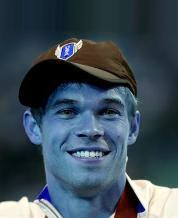

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-CelebA/000501.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)

Displaying the landmarks captured by MTCNN, blue dots represent box and red dots represent the facial landmarks

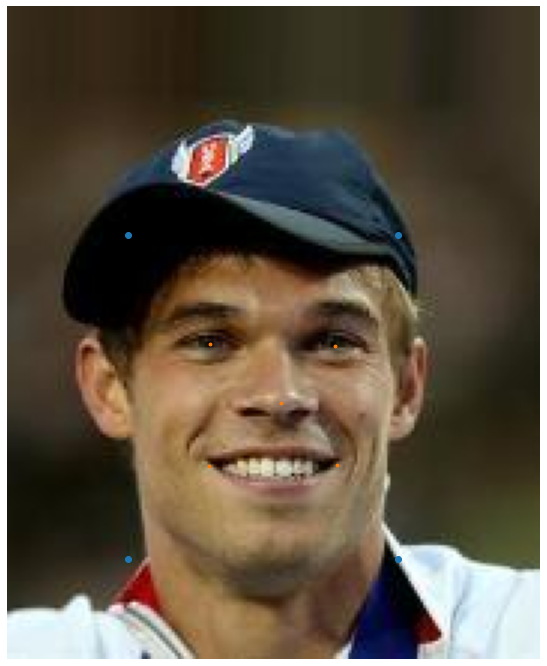

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(img)
ax.axis('off')
boxes, probs, landmarks = mtcnn_params(img)
for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

Generating facial blackout 

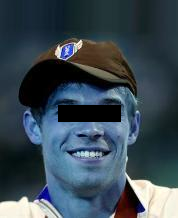

In [ ]:
boxes, probs, landmarks = mtcnn_params(img)
new_img = blackout(img, boxes, probs, landmarks)
cv2_imshow(new_img)

##Testing on 10 random images from each folder

NOTE : StyleGAN2 images are within another styleGAN2 images!

In [ ]:
celebA_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-CelebA"
ffhq_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-FFHQ"
attgan_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-ATTGAN"
gdwct_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-GDWCT"
stylegan_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-STYLEGAN"
stylegan2_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-STYLEGAN2/1-STYLEGAN2"
stargan_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-StarGAN"

####CelebA images

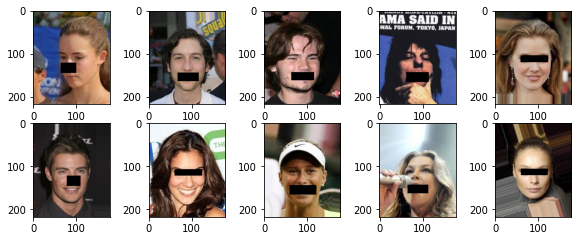

In [ ]:
path=celebA_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()



####FFHQ images




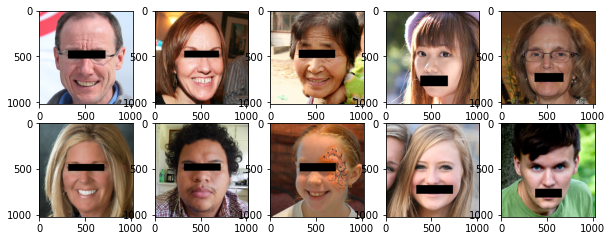

In [ ]:
path=ffhq_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()

####ATTGAN images

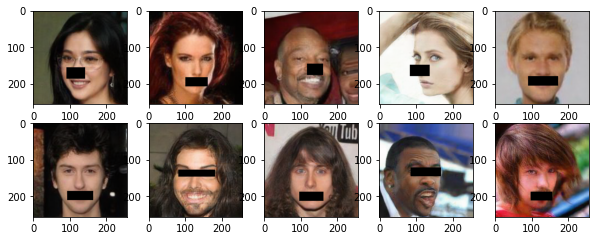

In [ ]:
path=attgan_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()

####GDWCT

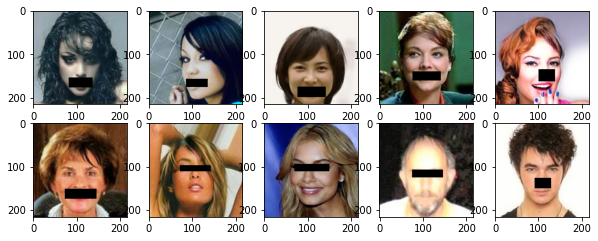

In [ ]:
path=gdwct_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()

####styleGAN images

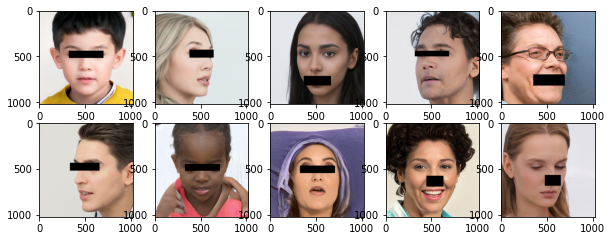

In [ ]:
path=stylegan_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()

####styleGAN2 images

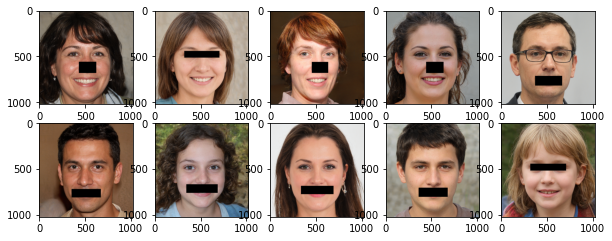

In [ ]:
path=stylegan2_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()

####StarGAN images

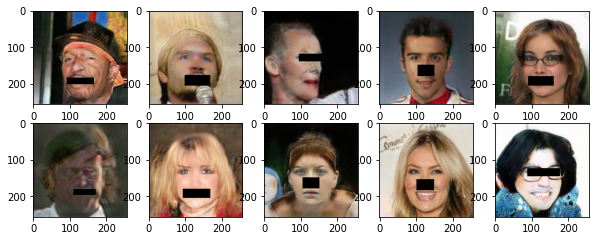

In [ ]:
path=stargan_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  plt.imshow(new_img)

plt.show()

## Verdict
Random Blackout function works pretty well and will help prevent model from overfitting on either of these facial features